In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

from tensorflow.keras.utils import to_categorical

In [2]:
from tensorflow.keras.models import model_from_json

In [3]:
import importlib

In [4]:
import plotting
from sklearn.metrics import accuracy_score

In [5]:
importlib.reload(plotting)

<module 'plotting' from '/gpfs/slac/atlas/fs1/u/rafaeltl/ML/L1BTag/Mar28/L1BTag/code/hls/notebooks/plotting.py'>

In [6]:
data_loc = '/gpfs/slac/atlas/fs1/d/rafaeltl/public/ML/L1RNN/datasets_2020_ff/'
file_str = 'Jan06_FlavFix_smear_1_std_xtd_zst.h5'

In [7]:
f5 = h5py.File(data_loc+file_str, 'r')

In [8]:
x_test = np.array( f5['x_test'] )
y_test = to_categorical ( np.array( f5['y_test'] ) )

In [9]:
# model_name = 'rnn_LSTM_50_10_nomask_LSTMKIvs_KRl20.0001'
# model_name = 'rnn_GRU_50_10_nomask_LSTMKIvs_KRl20.0001'
# model_name = 'rnn_LSTM_50_10_nomask_LSTMKIvs_KRl10.001l20.0001'



model_name = 'rnn_LSTM_64_10_nomask_KIvs_KRl20.0001'

In [10]:
arch_json = open('keras/model_'+model_name+'_arch.json', 'r').read()
model = model_from_json(arch_json)
model.load_weights(f'keras/model_{model_name}_weights.h5')

In [11]:
y_keras = model.predict(x_test, batch_size=2**10)

In [12]:
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))

Accuracy: 0.7243538998835856


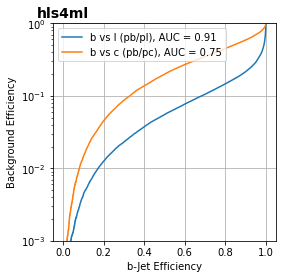

In [13]:
plt.figure(figsize=(4,4))
_ = plotting.makeRoc(y_test, y_keras)

In [14]:
import tensorflow_model_optimization as tfmot

In [15]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

In [16]:
x_train = np.array( f5['x_train'] )
y_train = to_categorical ( np.array( f5['y_train'] ) )

In [17]:
val_split = 0.1
num_train = y_train.shape[0] * (1 - val_split)
batch_size = 2**14
epochs = 150
end_step = np.ceil(num_train / batch_size).astype(np.int32) * epochs

In [18]:
# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

In [19]:
model_for_pruning = prune_low_magnitude(model, **pruning_params)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [20]:
import tensorflow as tf

In [21]:
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 6)]           0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 64)                18176     
_________________________________________________________________
dense_0 (Dense)              (None, 10)                650       
_________________________________________________________________
output_sigmoid (Dense)       (None, 3)                 33        
Total params: 18,859
Trainable params: 18,859
Non-trainable params: 0
_________________________________________________________________


In [23]:
model_for_pruning.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 6)]           0         
_________________________________________________________________
prune_low_magnitude_lstm1 (P (None, 64)                36099     
_________________________________________________________________
prune_low_magnitude_dense_0  (None, 10)                1292      
_________________________________________________________________
prune_low_magnitude_output_s (None, 3)                 65        
Total params: 37,456
Trainable params: 18,859
Non-trainable params: 18,597
_________________________________________________________________


In [24]:
import tempfile

In [25]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]


In [26]:
model_for_pruning.fit(x_train, y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=val_split,
                  callbacks=callbacks)

Epoch 1/150
 1/39 [..............................] - ETA: 0s - loss: 0.8825 - accuracy: 0.7246WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
39/39 [==============================] - 25s 642ms/step - loss: 0.8404 - accuracy: 0.7202 - val_loss: 0.8352 - val_accuracy: 0.7218
Epoch 2/150
39/39 [==============================] - 24s 623ms/step - loss: 0.8321 - accuracy: 0.7238 - val_loss: 0.8333 - val_accuracy: 0.7219
Epoch 3/150
39/39 [==============================] - 25s 634ms/step - loss: 0.8411 - accuracy: 0.7161 - val_loss: 0.8435 - val_accuracy: 0.7131
Epoch 4/150
39/39 [==============================] - 25s 630ms/step - loss: 0.8385 - accuracy: 0.7172 - val_loss: 0.8372 - val_accuracy: 0.7178
Epoch 5/150
39/39 [==============================] - 24s 621ms/s

In [27]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

In [28]:
model_for_export.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 6)]           0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 64)                18176     
_________________________________________________________________
dense_0 (Dense)              (None, 10)                650       
_________________________________________________________________
output_sigmoid (Dense)       (None, 3)                 33        
Total params: 18,859
Trainable params: 18,859
Non-trainable params: 0
_________________________________________________________________


In [29]:
y_keras_pruned = model_for_export.predict(x_test, batch_size=2**10)

In [30]:
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras_pruned, axis=1))))

Accuracy: 0.7236254781307168


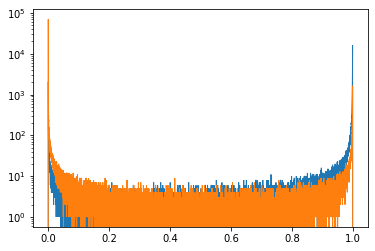

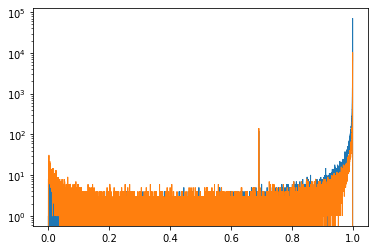

In [31]:
ppb_b = y_keras_pruned[:,0] [y_test[:,0] == 1]
ppc_b = y_keras_pruned[:,1] [y_test[:,0] == 1]
ppl_b = y_keras_pruned[:,2] [y_test[:,0] == 1]
    
ppc_c = y_keras_pruned[:,1] [y_test[:,1] == 1]
ppb_c = y_keras_pruned[:,0] [y_test[:,1] == 1]
    
ppl_l = y_keras_pruned[:,2] [y_test[:,2] == 1]
ppb_l = y_keras_pruned[:,0] [y_test[:,2] == 1]

plt.Figure()

plt.hist( ppb_b/(ppb_b+ppl_b), range=(0,1), bins=10000, histtype='step' )
plt.hist( ppb_l/(ppb_l+ppl_l), range=(0,1), bins=10000, histtype='step' )
plt.yscale('log')
plt.show()


plt.Figure()

plt.hist( ppb_b/(ppb_b+ppc_b), range=(0,1), bins=10000, histtype='step' )
plt.hist( ppb_c/(ppb_c+ppc_c), range=(0,1), bins=10000, histtype='step' )
plt.yscale('log')
plt.show()

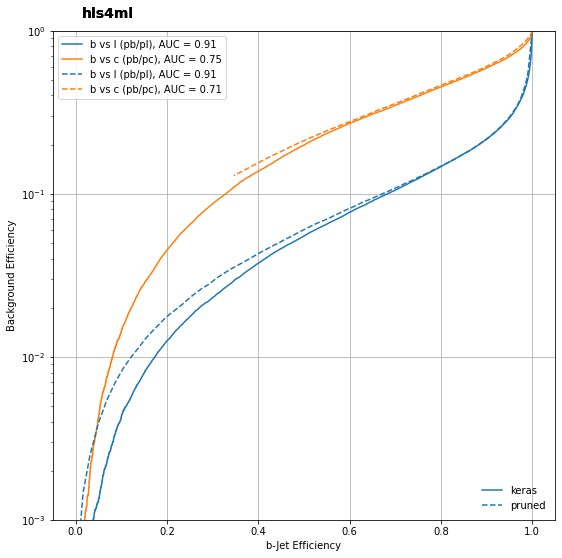

In [32]:
fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras)

plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_keras_pruned, linestyle='--')


from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['keras', 'pruned'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

In [33]:
pruned_model_json = model_for_export.to_json()
with open(f'keras/pruned_model_{model_name}_arch.json', "w") as json_file:
    json_file.write(pruned_model_json)

In [34]:
model_for_export.save_weights(f'keras/pruned_model_{model_name}_weights.h5')